# BUS 659 – Problem Set 2: Categorical Variables, Aggregation & P-Values

**Dataset:** `../datasets/movies_dataset.csv`  
**Goal:** Practice working with categorical data, creating aggregate statistics, and understanding p-values  
**Instructions:** Complete each question in the cells provided. Add additional cells as needed.

This problem set builds on concepts from Class 3:
- Handling categorical variables and memory optimization
- Using groupby() and agg() for summary statistics
- Understanding and calculating p-values
- Applying the Benjamini-Hochberg procedure

**Difficulty Level:** Questions 1-3 are warm-ups, 4-7 are moderate, 8-11 are challenging

# Matthew Tonks

In [70]:
# Setup: imports and configuration
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 120)

# Load the dataset
movies = pd.read_csv('../datasets/movies_dataset.csv')
print(f"Dataset shape: {movies.shape}")
print(f"\nColumns available:")
print(movies.columns.tolist())

Dataset shape: (3000, 21)

Columns available:
['movie_title', 'original_title', 'director_name', 'actor_1_name', 'actor_2_name', 'actor_3_name', 'budget', 'gross', 'title_year', 'release_date', 'duration', 'vote_average', 'vote_count', 'popularity', 'genres', 'country', 'original_language', 'overview', 'tagline', 'tmdb_id', 'imdb_id']


### Question 1: Basic Categorical Analysis 
a) Find the top 10 most common original languages in the dataset
b) Convert 'original_language' to categorical type and measure memory savings
c) Create a simple bar chart of the top 10 languages

153132 8602


<Axes: xlabel='count', ylabel='original_language'>

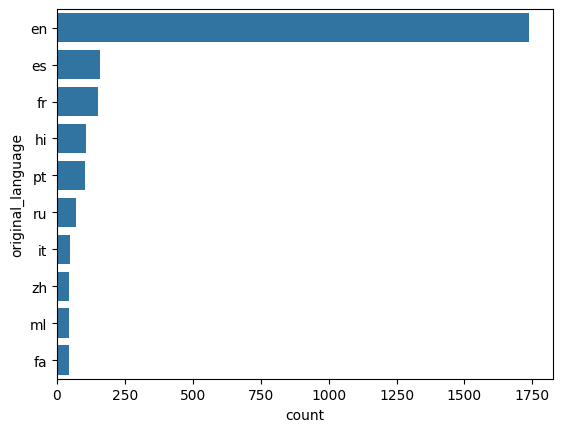

In [71]:
# Hints:
# - Use .value_counts() to count frequencies
top_10 = movies['original_language'].value_counts().head(10)

# - Use .memory_usage(deep=True) to check memory before and after
mem_before = movies['original_language'].memory_usage(deep=True)

# - Use .astype('category') to convert to categorical
movies['original_language'] = movies['original_language'].astype('category')

mem_after = movies['original_language'].memory_usage(deep=True)

print(mem_before, mem_after)

p = sns.countplot(data=movies, y='original_language', order=top_10.index)
p

### Question 2: Simple Aggregation 
Calculate basic statistics for each director who has made at least 3 movies:
a) Number of movies
b) Average budget
c) Average vote rating
Show the top 10 directors by average rating.

In [72]:
# Hints:
# - Use groupby('director_name').agg(...)
# - Filter with [director_stats['movie_count'] >= 3]
# - Sort with .sort_values('avg_rating', ascending=False)
group = movies.groupby('director_name').agg(
    movie_count=('movie_title', 'count'),
    avg_budget=('budget', 'mean'),
    avg_rating=('vote_average', 'mean')
)

director_stats = group[group['movie_count'] >= 3].sort_values('avg_rating', ascending=False)
director_stats.head(10)

,movie_count,avg_budget,avg_rating
director_name,,,
Jonathan Landeros,3,5.000000e+04,10.000000
Cy Feather,3,1.633600e+05,10.000000
Nicholas Onciul,4,1.817600e+04,9.250000
Matthew Cavanaugh,8,1.337500e+01,8.687500
Yen Ah Moi,10,2.341000e+05,7.900000
Denis Villeneuve,5,1.164000e+08,7.700200
Nadeem Baig,3,6.992078e+06,7.700000
James Gunn,3,2.116667e+08,7.675667
Christopher Nolan,3,1.516667e+08,7.567000


### Question 3: Genre Extraction and Counting 
The 'genres' column contains multiple genres separated by '|'.
a) Extract the first (primary) genre for each movie
b) Count how many unique primary genres exist
c) Show the distribution of the top 10 primary genres


primary genres count: 20
primary_genre
Drama          677
Comedy         493
Other          466
Action         386
Horror         262
Documentary    173
Thriller       133
Animation      112
Adventure      108
Romance         98
Crime           92
Name: count, dtype: int64


<Axes: xlabel='primary_genre', ylabel='count'>

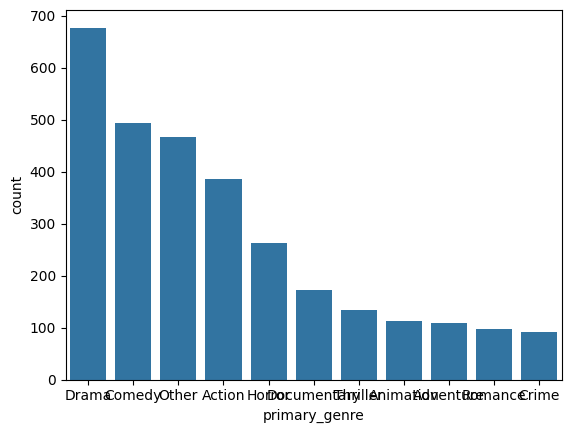

In [74]:
# Hints:
# - Use .str.split('|', expand=True)[0] to get first genre
# - For 'Other' category: use np.where() or .apply(lambda x: x if x in top_8 else 'Other')
# - plt.pie() needs values and labels
movies['primary_genre'] = movies['genres'].str.split('|', expand=True)[0]
print('primary genres count:', len(movies['primary_genre'].unique()))


top_10 = movies['primary_genre'].value_counts().head(10)
movies['primary_genre'] = np.where(movies['primary_genre'].isin(top_10.index), movies['primary_genre'], 'Other')

# Show counts for all genres including 'Other'
genre_counts = movies['primary_genre'].value_counts()
print(genre_counts)

p = sns.countplot(data=movies, x='primary_genre', order=genre_counts.index)
p

### Question 4: Country and Language Analysis 
Analyze the relationship between 'country' and 'original_language':
a) Find the top 10 countries by movie count
b) For countries with 20+ movies, calculate the percentage of English-language films
c) Create a horizontal bar chart showing this percentage
d) Which non-English speaking country produces the most English-language films?

In [75]:
# Hints:
# - Some movies have multiple countries (e.g., 'USA|UK'), handle the first one
# - Use: movies['country'].str.split('|', expand=True)[0]
# - Calculate percentage: (movies['original_language'] == 'en').mean() * 100
# - Traditional non-English countries might include France, Germany, Japan, etc.

movies['primary_country'] = movies['country'].str.split('|', expand=True)[0]
percent_english = (movies['original_language'] == 'en').mean() * 100
print(f"Percentage of movies in English: {percent_english:.2f}%")

Percentage of movies in English: 57.93%


### Question 5: Multi-Level Aggregation with ROI 
Create a summary table grouped by BOTH primary genre AND decade (1970s, 1980s, etc.):
a) Calculate ROI for each movie (gross/budget)
b) Create decade categories from title_year
c) Group by genre and decade showing:
   - Number of movies
   - Median ROI
   - Success rate (% of movies with ROI > 2)
d) Create a heatmap showing median ROI by genre and decade

<Axes: ylabel='primary_genre-decade'>

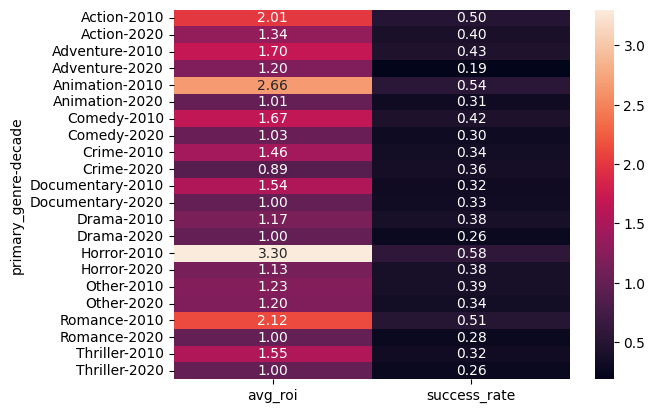

In [76]:
# Hints:
# - Create decade: movies['decade'] = (movies['title_year'] // 10) * 10
# - ROI calculation: movies['roi'] = movies['gross'] / movies['budget'].replace(0, np.nan)
# - Success rate: (movies['roi'] > 2).mean()
# - For heatmap: pivot_table then sns.heatmap()

movies['decade'] = (movies['title_year'] // 10) * 10
movies['roi'] = movies['gross'] / movies['budget'].replace(0, np.nan)
success_rate = (movies['roi'] > 2).mean()

decade_agg = movies.groupby(['primary_genre', 'decade']).agg(
    avg_roi=('roi', 'median'),
    success_rate=('roi', lambda x: (x > 2).mean())
)

p = sns.heatmap(decade_agg, annot=True,  fmt=".2f")
p

### Question 6: Statistical Testing - Original vs English Films
Test whether English-language films have significantly different ratings than non-English films:
a) Create two groups: English (original_language == 'en') vs Non-English
b) Calculate descriptive statistics for each group
c) Perform a two-sample t-test


In [77]:
# Hints:
# - Use stats.ttest_ind(group1, group2) for t-test
# - Cohen's d = (mean1 - mean2) / pooled_std
# - Pooled std formula: np.sqrt(((n1-1)*s1**2 + (n2-1)*s2**2) / (n1+n2-2))
# - Effect size interpretation: <0.2 small, <0.5 medium, <0.8 large
english = movies[movies['original_language'] == 'en']['vote_average'].dropna()
non_english = movies[movies['original_language'] != 'en']['vote_average'].dropna()

stats_result = stats.ttest_ind(english, non_english, equal_var=False)
print(f"T-test result: statistic={stats_result.statistic}, p-value={stats_result.pvalue}")

# Calculate effect size
mean1, mean2 = english.mean(), non_english.mean()
std1, std2 = english.std(), non_english.std()
n1, n2 = english.count(), non_english.count()
pooled_std = np.sqrt(((n1-1)*std1**2 + (n2-1)*std2**2) / (n1+n2-2))
cohens_d = (mean1 - mean2) / pooled_std if pooled_std else 0
print(f"Cohen's d: {cohens_d}")


T-test result: statistic=-0.21262438661450803, p-value=0.8316362494490199
Cohen's d: -0.007909206082051333


### Question 7: Time Series Analysis with Moving Averages 
Analyze trends in the movie industry over time:
a) Group by year and calculate median budget and average gross
b) Calculate 5-year moving averages for both metrics
c) Calculate year-over-year percentage change in average gross
d) Create a dual-axis plot showing budget trends and YoY growth
e) Identify the year with highest growth and the year with biggest decline

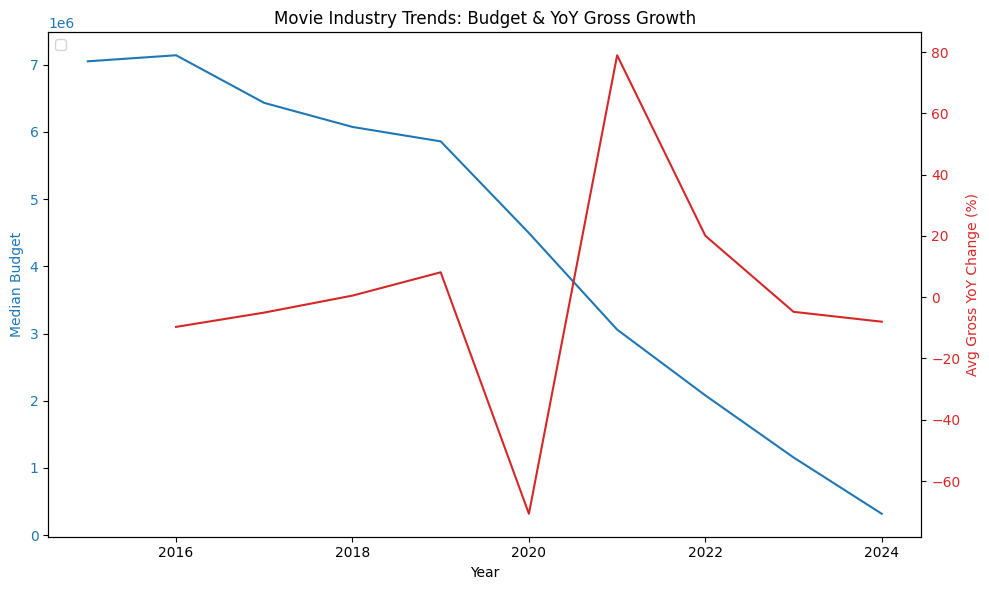

Highest YoY avg gross growth: 2021 (78.98%)
Biggest YoY avg gross decline: 2020 (-70.70%)


In [79]:
# Hints:
# - Use .rolling(window=5, min_periods=1).mean() for moving average
# - Use .pct_change() * 100 for percentage change
# - For dual axis: ax2 = ax1.twinx()
# - Use .idxmax() and .idxmin() to find max/min years

# a) Group by year and calculate median budget and average gross
yearly = movies.groupby('title_year').agg(
    median_budget=('budget', 'median'),
    avg_gross=('gross', 'mean')
).reset_index()

# b) Calculate 5-year moving averages
yearly['median_budget_ma5'] = yearly['median_budget'].rolling(window=5, min_periods=1).mean()
yearly['avg_gross_ma5'] = yearly['avg_gross'].rolling(window=5, min_periods=1).mean()

# c) Year-over-year percentage change in average gross
yearly['avg_gross_yoy'] = yearly['avg_gross'].pct_change() * 100

# d) Dual-axis plot
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot median budget (5yr MA)
sns.lineplot(x='title_year', y='median_budget_ma5', data=yearly, ax=ax1, color='tab:blue')
ax1.set_ylabel('Median Budget', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Create secondary axis and plot avg gross YoY change
ax2 = ax1.twinx()
sns.lineplot(x='title_year', y='avg_gross_yoy', data=yearly, ax=ax2, color='tab:red')
ax2.set_ylabel('Avg Gross YoY Change (%)', color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')

# Add legends separately to avoid overlap
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, ['Median Budget (5yr MA)', 'Avg Gross YoY Change'], loc='upper left')

ax1.set_xlabel('Year')
ax1.set_title('Movie Industry Trends: Budget & YoY Gross Growth')
fig.tight_layout()
plt.show()

# e) Identify the year with highest growth and biggest decline
max_growth_year = yearly.loc[yearly['avg_gross_yoy'].idxmax(), 'title_year']
max_growth_value = yearly['avg_gross_yoy'].max()
min_growth_year = yearly.loc[yearly['avg_gross_yoy'].idxmin(), 'title_year']
min_growth_value = yearly['avg_gross_yoy'].min()
print(f"Highest YoY avg gross growth: {max_growth_year} ({max_growth_value:.2f}%)")
print(f"Biggest YoY avg gross decline: {min_growth_year} ({min_growth_value:.2f}%)")



### Question 8: Multiple Testing with Benjamini-Hochberg 
Test if the average ROI for each of the top 20 genres is significantly different from the overall average:
a) Calculate p-values for each genre using one-sample t-tests
b) Apply the Benjamini-Hochberg correction (FDR = 0.05)
c) Create a visualization showing p-values, BH critical values, and which genres remain significant


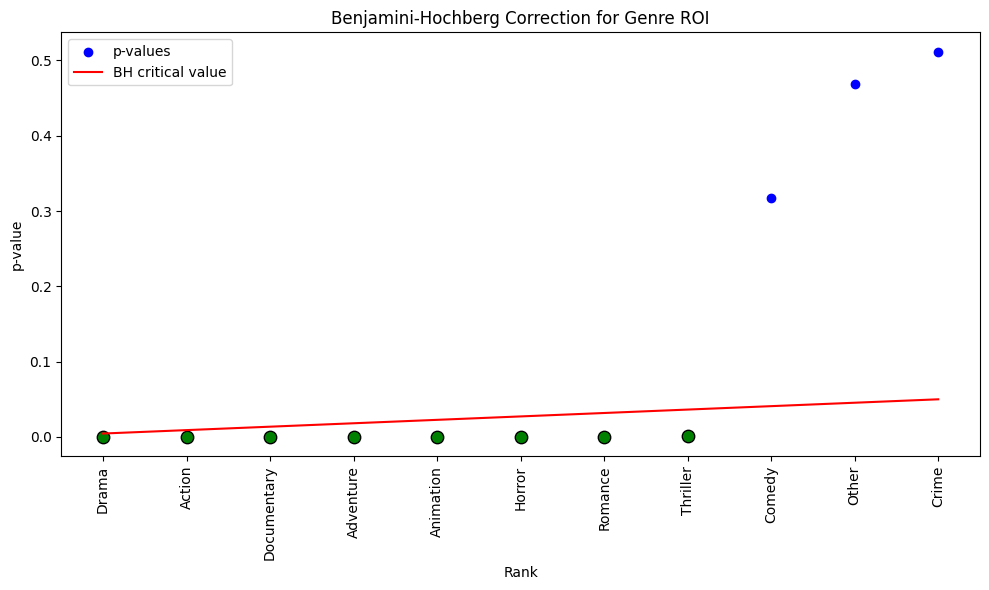

Significant genres after BH correction:
         genre     mean_roi        p_value
0        Drama    27.360135   0.000000e+00
3       Action     5.691603   0.000000e+00
5  Documentary    11.421616  1.690072e-310
8    Adventure     3.188503  2.381765e-290
7    Animation     5.575943  5.372972e-261
4       Horror    52.509847  8.383432e-234
9      Romance    12.926693  2.033868e-189
6     Thriller  1130.597551   1.402147e-03


In [80]:
# Hints for BH procedure:
# 1. Sort p-values from smallest to largest
# 2. Add rank column: results['rank'] = range(1, len(results) + 1)
# 3. Calculate BH critical value: (rank / m) * Q where m = total tests, Q = 0.05
# 4. Find largest rank where p_value < BH_critical_value
# 5. All tests with rank <= that rank are significant
# Use stats.ttest_1samp(genre_data, overall_mean) for one-sample test

# a) Calculate p-values for each genre using one-sample t-tests
top_20_genres = movies['primary_genre'].value_counts().head(20).index
overall_mean_roi = movies['roi'].mean()

results = []
for genre in top_20_genres:
    genre_data = movies.loc[movies['primary_genre'] == genre, 'roi'].dropna()
    ttest = stats.ttest_1samp(genre_data, overall_mean_roi, nan_policy='omit')
    results.append({'genre': genre, 'p_value': ttest.pvalue, 'mean_roi': genre_data.mean(), 'n': genre_data.count()})

results = pd.DataFrame(results).sort_values('p_value')

# b) Benjamini-Hochberg correction
m = len(results)
Q = 0.05
results['rank'] = np.arange(1, m + 1)
results['BH_critical'] = (results['rank'] / m) * Q
results['significant'] = results['p_value'] < results['BH_critical']

# c) Visualization
plt.figure(figsize=(10, 6))
plt.scatter(results['rank'], results['p_value'], label='p-values', color='blue')
plt.plot(results['rank'], results['BH_critical'], label='BH critical value', color='red')
for i, row in results.iterrows():
    if row['significant']:
        plt.scatter(row['rank'], row['p_value'], color='green', s=80, edgecolor='black')
plt.xlabel('Rank')
plt.ylabel('p-value')
plt.title('Benjamini-Hochberg Correction for Genre ROI')
plt.legend()
plt.xticks(results['rank'], results['genre'], rotation=90)
plt.tight_layout()
plt.show()

print("Significant genres after BH correction:")
print(results.loc[results['significant'], ['genre', 'mean_roi', 'p_value']])



### Question 9: Actor Success Score Analysis 
Create a comprehensive 'success score' for actors:
a) For each actor_1_name with at least 5 movies, calculate:
   - Average gross revenue
   - Average rating
   - Consistency score (1 / std_dev of ratings)
   - Star power (log of total vote_count across all their movies)
b) Create a weighted success score: (avg_gross * avg_rating * consistency * star_power) / 1e9
c) Find the top 15 actors by this score
d) Create a scatter plot of avg_gross vs avg_rating, with point size representing the success score

In [68]:
# Hints:
# - Consistency: use 1 / (std + 1) to avoid division by zero
# - Star power: np.log(total_votes + 1)
# - For scatter with sized points: plt.scatter(x, y, s=sizes*scale_factor, alpha=0.6)
# - Consider normalizing the success score for better visualization

## Question 10 

Suppose you are an executive at a talent agency. You're tasked with deciding which actors to pitch to Steven Spielberg for his new film **The Explorer's Ghost**. You've made the analysis in the question above and need to describe the logic to Mr. Spielberg. Write a paragraph or two describing the analysis to him and suggesting a few actors you'd like him to consider. 

### Question 11: Comprehensive Dashboard (Extra Credit)
Create a 4-panel dashboard analyzing the evolution of cinema:

**Panel 1:** Genre popularity over decades (stacked area chart)
**Panel 2:** Budget vs Gross colored by decade with trend lines
**Panel 3:** Average ratings by genre and decade (heatmap)
**Panel 4:** Distribution of movie durations by decade (box plots)

Additionally:
- Perform ANOVA to test if ratings differ significantly across decades
- Calculate which decade had the best ROI
- Write a 3-sentence summary of your findings

In [69]:
# Hints for complex visualization:
# fig, axes = plt.subplots(2, 2, figsize=(15, 12))
# 
# Panel 1 (stacked area): 
# - Pivot data first: genre_decade.pivot()
# - axes[0,0].stackplot() or use pandas .plot(kind='area', stacked=True)
# 
# Panel 2 (scatter with trends):
# - Use different colors/markers per decade
# - Add trend line with np.polyfit() and np.poly1d()
# 
# Panel 3 (heatmap):
# - Create pivot table first
# - sns.heatmap(pivot_data, ax=axes[1,0])
# 
# Panel 4 (box plots):
# - Group data by decade
# - axes[1,1].boxplot([data_1970s, data_1980s, ...])
# 
# ANOVA: stats.f_oneway(group1, group2, group3, ...)

### Your 3-Sentence Summary:
<!-- Write your summary here after completing the analysis -->